# Steel Temperature Forecast

## Project Description

In order to optimize production costs, the metallurgical plant "Tak Zakalaem Stal" Ltd. wants to reduce electricity consumption at the steel processing stage. It is required to build a model that predicts the temperature of the steel

### Steel Processing Stage 

Steel is processed in a metal ladle with a capacity of about 100 tons. In order for the ladle to withstand high temperatures, it is lined with refractory bricks from the inside. Molten steel is poured into a ladle and heated to the desired temperature with graphite electrodes. They are installed in the lid of the bucket.

Sulfur is removed from the alloy (desulfurization), the chemical composition is corrected by mixing with additions, and samples are taken. Steel is alloyed. Its composition is changed by feeding pieces of alloy from a bunker for bulk materials or wire through a special tribe apparatus.

Before feeding the alloying additives for the first time, the temperature of the steel is measured and its chemical analysis is carried out. Then the temperature is raised for several minutes, alloying materials are added and the alloy is purged with an inert gas. Then it is stirred and measured again. This cycle is repeated until the target chemical composition and optimum melting temperature are reached.

After that the molten steel is taken to finish the metal or to enter the continuous casting machine. From there, the finished product comes out in the form of slab blanks

## Imports

In [65]:
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.dummy import DummyRegressor

import warnings
from IPython.display import display
from functools import reduce
import time

## Explaratory Data Analysis

### Data Description

- `data_arc.csv` - electrode data;


- `data_bulk.csv` - data on the supply of bulk materials (*volume*);


- `data_bulk_time.csv` - data on the supply of bulk materials (*time*);


- `data_gas.csv` - data on alloy gas purge;


- `data_temp.csv` - temperature measurement results;


- `data_wire.csv` - data on wire materials (*volume*);


- `data_wire_time.csv` - data on wire materials (*time*).

### Datasets Loading & Exploration

In [66]:
data_arc = pd.read_csv('/datasets/final_steel/data_arc.csv')
data_bulk = pd.read_csv('/datasets/final_steel/data_bulk.csv')
data_bulk_time = pd.read_csv('/datasets/final_steel/data_bulk_time.csv')
data_gas = pd.read_csv('/datasets/final_steel/data_gas.csv')
data_temp = pd.read_csv('/datasets/final_steel/data_temp.csv')
data_wire = pd.read_csv('/datasets/final_steel/data_wire.csv')
data_wire_time = pd.read_csv('/datasets/final_steel/data_wire_time.csv')

data_arc.name = 'data_arc'
data_bulk.name = 'data_bulk'
data_bulk_time.name = 'data_bulk_time'
data_gas.name = 'data_gas'
data_temp.name = 'data_temp'
data_wire.name = 'data_wire'
data_wire_time.name = 'data_wire_time'

dfs = [data_arc, data_bulk, data_bulk_time, data_gas, data_temp, data_wire, data_wire_time]

for df in dfs:
    print('\033[1m' + df.name + '\033[0m')
    display(df.head(6))
    display(df.info())
    display(df.describe())
    print('__________________________________________________________________________________')
    print(' ')

data_arc


,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397
5,2,2019-05-03 11:34:14,2019-05-03 11:36:31,0.438063,0.283043


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


None

,key,Активная мощность,Реактивная мощность
count,14876.000000,14876.000000,14876.000000
mean,1615.220422,0.670441,0.452592
std,934.571502,0.408159,5.878702
min,1.000000,0.030002,-715.504924
25%,806.000000,0.395297,0.290991
50%,1617.000000,0.555517,0.415962
75%,2429.000000,0.857034,0.637371
max,3241.000000,3.731596,2.676388


__________________________________________________________________________________
 
data_bulk


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0
5,6,NaN,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,204.0,NaN,201.0,154.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


None

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
count,3129.000000,252.000000,22.000000,1298.000000,1014.000000,77.000000,576.000000,25.000000,1.0,19.000000,176.000000,177.000000,2450.000000,18.000000,2806.000000,2248.000000
mean,1624.383509,39.242063,253.045455,113.879045,104.394477,107.025974,118.925347,305.600000,49.0,76.315789,83.284091,76.819209,260.471020,181.111111,170.284747,160.513345
std,933.337642,18.277654,21.180578,75.483494,48.184126,81.790646,72.057776,191.022904,NaN,21.720581,26.060347,59.655365,120.649269,46.088009,65.868652,51.765319
min,1.000000,10.000000,228.000000,6.000000,12.000000,11.000000,17.000000,47.000000,49.0,63.000000,24.000000,8.000000,53.000000,151.000000,16.000000,1.000000
25%,816.000000,27.000000,242.000000,58.000000,72.000000,70.000000,69.750000,155.000000,49.0,66.000000,64.000000,25.000000,204.000000,153.250000,119.000000,105.000000
50%,1622.000000,31.000000,251.500000,97.500000,102.000000,86.000000,100.000000,298.000000,49.0,68.000000,86.500000,64.000000,208.000000,155.500000,151.000000,160.000000
75%,2431.000000,46.000000,257.750000,152.000000,133.000000,132.000000,157.000000,406.000000,49.0,70.500000,102.000000,106.000000,316.000000,203.500000,205.750000,205.000000
max,3241.000000,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.0,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000


__________________________________________________________________________________
 
data_bulk_time


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:21:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:03:52,NaN,2019-05-03 11:03:52,2019-05-03 11:03:52
1,2,NaN,NaN,NaN,2019-05-03 11:46:38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:40:20,NaN,2019-05-03 11:40:20,2019-05-03 11:40:20
2,3,NaN,NaN,NaN,2019-05-03 12:31:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:09:40,NaN,2019-05-03 12:09:40,2019-05-03 12:09:40
3,4,NaN,NaN,NaN,2019-05-03 12:48:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:41:24,NaN,2019-05-03 12:41:24,2019-05-03 12:41:24
4,5,NaN,NaN,NaN,2019-05-03 13:18:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:12:56,NaN,2019-05-03 13:12:56,2019-05-03 13:12:56
5,6,NaN,NaN,NaN,2019-05-03 13:59:24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:53:27,NaN,2019-05-03 13:53:27,2019-05-03 13:53:27


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


None

,key
count,3129.000000
mean,1624.383509
std,933.337642
min,1.000000
25%,816.000000
50%,1622.000000
75%,2431.000000
max,3241.000000


__________________________________________________________________________________
 
data_gas


,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692
5,6,11.273392


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


None

,key,Газ 1
count,3239.000000,3239.000000
mean,1621.861377,11.002062
std,935.386334,6.220327
min,1.000000,0.008399
25%,812.500000,7.043089
50%,1622.000000,9.836267
75%,2431.500000,13.769915
max,3241.000000,77.995040


__________________________________________________________________________________
 
data_temp


,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0
5,2,2019-05-03 11:37:27,1581.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           15907 non-null  int64  
 1   Время замера  15907 non-null  object 
 2   Температура   13006 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 372.9+ KB


None

,key,Температура
count,15907.000000,13006.000000
mean,1607.880870,1591.840920
std,942.212073,21.375851
min,1.000000,1191.000000
25%,790.000000,1581.000000
50%,1618.000000,1591.000000
75%,2427.000000,1601.000000
max,3241.000000,1705.000000


__________________________________________________________________________________
 
data_wire


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,6,99.109917,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


None

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,3081.000000,3055.000000,1079.000000,63.000000,14.000000,1.000,73.000000,11.000000,19.000000,29.000000
mean,1623.426485,100.895853,50.577323,189.482681,57.442841,15.132,48.016974,10.039007,53.625193,34.155752
std,932.996726,42.012518,39.320216,99.513444,28.824667,NaN,33.919845,8.610584,16.881728,19.931616
min,1.000000,1.918800,0.030160,0.144144,24.148801,15.132,0.034320,0.234208,45.076721,4.622800
25%,823.000000,72.115684,20.193680,95.135044,40.807002,15.132,25.053600,6.762756,46.094879,22.058401
50%,1619.000000,100.158234,40.142956,235.194977,45.234282,15.132,42.076324,9.017009,46.279999,30.066399
75%,2434.000000,126.060483,70.227558,276.252014,76.124619,15.132,64.212723,11.886057,48.089603,43.862003
max,3241.000000,330.314424,282.780152,385.008668,113.231044,15.132,180.454575,32.847674,102.762401,90.053604


__________________________________________________________________________________
 
data_wire_time


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:11:41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:46:10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:13:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:48:05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:18:15,2019-05-03 13:32:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,6,2019-05-03 13:59:02,2019-05-03 13:59:54,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


None

,key
count,3081.000000
mean,1623.426485
std,932.996726
min,1.000000
25%,823.000000
50%,1619.000000
75%,2434.000000
max,3241.000000


__________________________________________________________________________________
 


### Conclusions 1.0

After the initial data analysis, the following list can be distinguished for data preprocessing stage:

1. **`data_arc`**

    - **`Arc heating start`**, **`Arc heating end`** / convert to date-time format
    - **`Reactive power`**, **`Reactive power`** / study distributions, outliers, check for potential multicollinearity problem
   
   
2. **`data_bulk`**, **`data_wire`**

    - Determine the nature of multiple missing values
    
    
3. **`data_bulk_time`**, **`data_wire_time`**

    - Convert to date-time format
    
    
4. **`data_gas`**

    - Study distribution
    
    
5. **`data_temp`**

    - There are missing values in **`Temperature`**
    - **`Temperature`** / explore distributions, outliers
    
------

6. Check **if timeline is correct**


The processing cycle includes numerous heatings of the steel using the electrodes. It should be checked whether the temperature measurements and the initial and final heatings by the arc are correctly placed on the time scale. Perhaps there are such batches where temperature measurements began long before the first arc heating - which may indicate incorrect data in the dataframe

7. Determine the **target and features** that will be used to train potential models for steel temperature prediction

### Function for Distribution Study

In [67]:
def dist_graph(df, field):

    f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={'height_ratios': (0.2, 0.8)}, figsize=(15, 7))

    sns.boxplot(df[field], ax=ax_box, color='mediumslateblue')
    sns.distplot(df[field], bins=50, ax=ax_hist, kde=False, color='midnightblue', label = field)
    


    mean = df[field].mean()
    plt.axvline(mean, 0, 1, color='red', label='mean')

    ax_box.set(yticks=[])
    ax_box.set(xlabel=None)
    ax_box.axes.set_title(field + ' | Распределение', fontsize=18)
    ax_hist.set_xlabel(field, fontsize=12)
    sns.despine(ax=ax_hist)
    sns.despine(ax=ax_box, left=True)
    plt.legend(fontsize=14)

### `data_arc`

#### Date Format

In [68]:
data_arc['Начало нагрева дугой'] = pd.to_datetime(data_arc['Начало нагрева дугой'], format='%Y-%m-%dT%H:%M:%S')
data_arc['Конец нагрева дугой'] = pd.to_datetime(data_arc['Конец нагрева дугой'], format='%Y-%m-%dT%H:%M:%S')

# Check 
data_arc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   key                   14876 non-null  int64         
 1   Начало нагрева дугой  14876 non-null  datetime64[ns]
 2   Конец нагрева дугой   14876 non-null  datetime64[ns]
 3   Активная мощность     14876 non-null  float64       
 4   Реактивная мощность   14876 non-null  float64       
dtypes: datetime64[ns](2), float64(2), int64(1)
memory usage: 581.2 KB


#### Power | Distribution

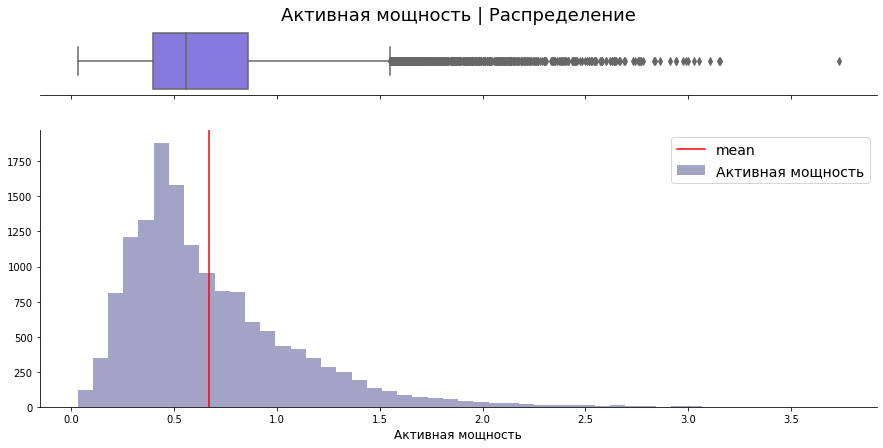

In [69]:
warnings.simplefilter(action='ignore', category=FutureWarning)

dist_graph(data_arc, 'Активная мощность')

* The distribution of **`Активной мощности`** **skewed right**


* Values range from 0 to 4


* We are not getting rid of anomalies by defining statistical outliers (**Q1 - 1.5IQR** AND **Q3 + 1.5IQR**) at this stage. By doing so, we are going to lose a lot of data from the right side. Moreover, in order to make a correct conclusion about anomalies for such a value, one will need to get an expert opinion on the matter.

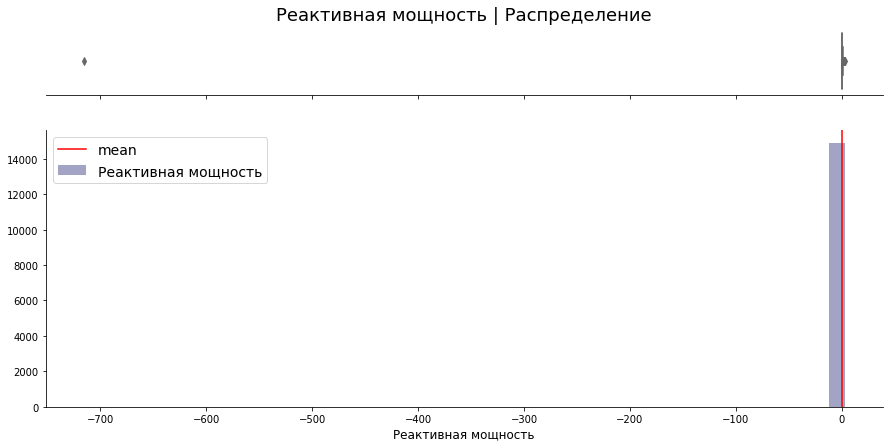

In [70]:
dist_graph(data_arc, 'Реактивная мощность')

It can be seen that there is 1 left outlier in the data, which is very different from the rest of the data. Since there is only one, we can remove one batch entirely, which will not affect our data (distributions) and models training.

In [71]:
# Let's see which batch contains this value of Реактивная Мощность

delete_cond = data_arc['Реактивная мощность'].min()
delete_key = data_arc[data_arc['Реактивная мощность'] == delete_cond]['key'].item()


# Remove this batch from each dataframe in the list

dfs = [df[(df['key'] != delete_key)] for df in dfs]

# Delete this batch from each dataframe separately

data_arc = data_arc[data_arc['key'] != delete_key]
data_bulk = data_bulk[data_bulk['key'] != delete_key]
data_bulk_time = data_bulk_time[data_bulk_time['key'] != delete_key]
data_gas = data_gas[data_gas['key'] != delete_key]
data_temp = data_temp[data_temp['key'] != delete_key]
data_wire = data_wire[data_wire['key'] != delete_key]
data_wire_time = data_wire_time[data_wire_time['key'] != delete_key]


# List check

for df in dfs:
    display(df[df['key'] == delete_key])

# Checking each datafra,e separately

display(data_arc[data_arc['key'] == delete_key])

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15


,key,Газ 1


,key,Время замера,Температура


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9


,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность


Let's display once again the distribution of **`Реактивная мощность`**

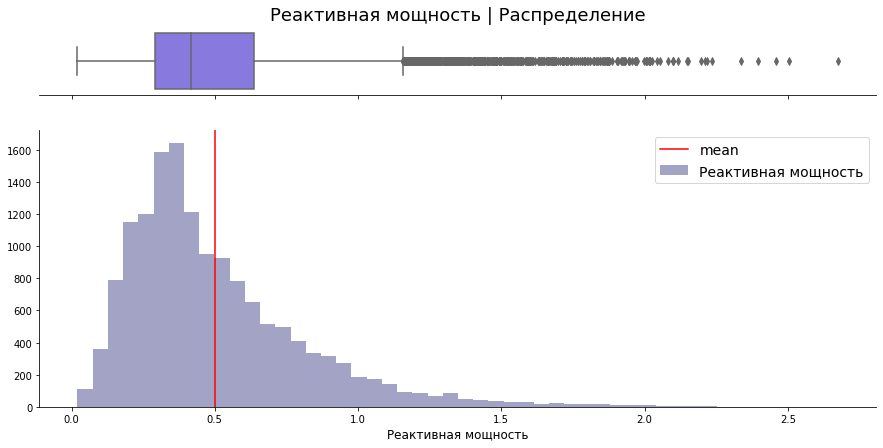

In [72]:
dist_graph(data_arc, 'Реактивная мощность')

We see a similar result for **`Реактивная мощность`**

* Distribution is skewed to the right


* Values range from 0 to 3


* We are again not going to get rid of the anomalies (statistically) for the same reasons

#### Check for multicollinearity

Text(0.8, 0.2, 'Pearson Correlation Coefficient = 0.96')

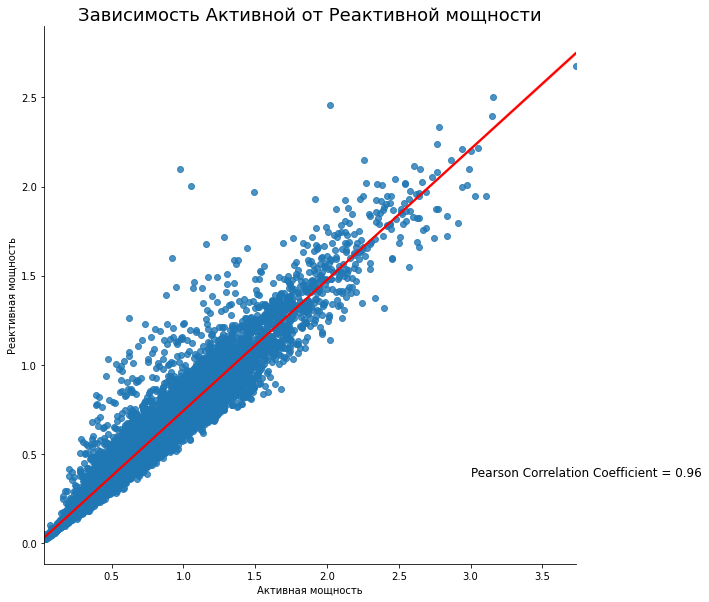

In [73]:
sns.lmplot(x='Активная мощность', y='Реактивная мощность', data=data_arc, height=8, line_kws={'color': 'red'})

# plt.rcParams['figure.figsize'] = [17,5]
plt.title('Зависимость Активной от Реактивной мощности', fontsize=18)
plt.figtext(.8, .2, "Pearson Correlation Coefficient = " + \
            str(round(data_arc['Активная мощность'].corr(data_arc['Реактивная мощность']), 2)), fontsize=12)

Thus, we can observe a **strong positive linear relationship** between 2 features: **`Активная мощность`, `Реактивная мощность`**

This fact gives rise to the problem of **multicollinearity**. Predictions may turn out to be inaccurate - it will be difficult to interpret the influence of certain factors on the target.

To avoid the identified problem, instead of using 2 features or only 1 of them while forming the training sample - we will form a new feature. We will calculate  **`Полная мощность`** (*Apparent Power*), which is the square root of the sum of the squares of 2 given powers (*Active Power*, *Reactive Power*).

**Полная мощность** formula:

$ S = \sqrt{(P^{2} + Q^{2})} $


$ S $ - Apparent Power,
$ P $ - Active Power,
$ Q $ - Reactive Power

### `data_bulk`,  `data_wire`

#### Missing Values

In [74]:
data_bulk.info(), data_wire.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3128 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3128 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   575 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2805 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 415.4 KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 3080 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------ 

(None, None)

We see that there is a huge number of **None-values** in 2 datasets.

We will leave these gaps blank, since it is the None value that indicates to us some of the alloying additives were not used in the steel processing cycle.

### `data_bulk_time`, `data_wire_time`

#### Date Format

In [75]:
data_bulk_time.loc[:, data_bulk_time.columns != 'key'] = \
    data_bulk_time.loc[:, data_bulk_time.columns != 'key'].apply(pd.to_datetime, format='%Y-%m-%dT%H:%M:%S')

data_wire_time.loc[:, data_wire_time.columns != 'key'] = \
    data_wire_time.loc[:, data_wire_time.columns != 'key'].apply(pd.to_datetime, format='%Y-%m-%dT%H:%M:%S')

data_bulk_time.info()
data_wire_time.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3128 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   key      3128 non-null   int64         
 1   Bulk 1   252 non-null    datetime64[ns]
 2   Bulk 2   22 non-null     datetime64[ns]
 3   Bulk 3   1298 non-null   datetime64[ns]
 4   Bulk 4   1014 non-null   datetime64[ns]
 5   Bulk 5   77 non-null     datetime64[ns]
 6   Bulk 6   575 non-null    datetime64[ns]
 7   Bulk 7   25 non-null     datetime64[ns]
 8   Bulk 8   1 non-null      datetime64[ns]
 9   Bulk 9   19 non-null     datetime64[ns]
 10  Bulk 10  176 non-null    datetime64[ns]
 11  Bulk 11  177 non-null    datetime64[ns]
 12  Bulk 12  2450 non-null   datetime64[ns]
 13  Bulk 13  18 non-null     datetime64[ns]
 14  Bulk 14  2805 non-null   datetime64[ns]
 15  Bulk 15  2248 non-null   datetime64[ns]
dtypes: datetime64[ns](15), int64(1)
memory usage: 415.4 KB
<class 'pandas.core.fra

### `data_gas`

#### Distribution

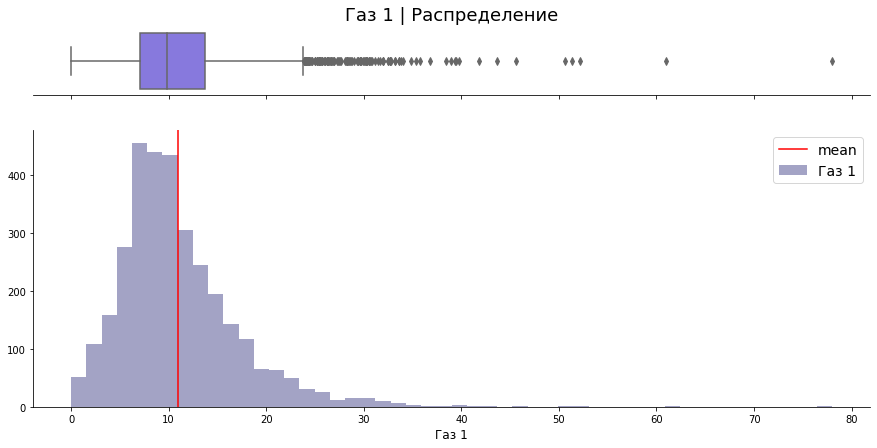

In [76]:
dist_graph(data_gas, 'Газ 1')

* The distribution looks quite **symmetric** (median and mean are almost the same)


* Nevertheless, we can observe a **long tail on the right side** (a big number of **right outlayers**) - we will not remove them, since this issue requires expert evaluation and it would be incorrect to remove them statistically from the business point of view

### `data_temp`

#### Date Format

In [77]:
data_temp['Время замера'] = pd.to_datetime(data_temp['Время замера'], format='%Y-%m-%dT%H:%M:%S')

#### Missing Values

In [78]:
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15903 entries, 0 to 15906
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   key           15903 non-null  int64         
 1   Время замера  15903 non-null  datetime64[ns]
 2   Температура   13002 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 497.0 KB


In [79]:
data_temp['key'].value_counts().sort_values(ascending=False)

1513    16
44      16
46      16
1214    16
1689    15
        ..
2876     2
1211     2
776      2
279      1
195      1
Name: key, Length: 3215, dtype: int64

Let's take a closer look at the batches: **2500, 195, 279**

In [80]:
display(data_temp[data_temp['key'] == 2500],data_temp[data_temp['key'] == 195],data_temp[data_temp['key'] == 279])

,key,Время замера,Температура
12267,2500,2019-08-06 03:11:31,1539.0
12268,2500,2019-08-06 03:24:43,NaN
12269,2500,2019-08-06 03:25:16,NaN
12270,2500,2019-08-06 03:28:21,NaN


,key,Время замера,Температура
1100,195,2019-05-10 14:10:23,1583.0


,key,Время замера,Температура
1554,279,2019-05-13 23:07:28,1603.0


### Conclusions 2.0

* The dataframe contains the target that we are going to predict - **`Температура`** (*temperature*). **The target feature is precisely the final temperature measurement** of the steel alloy after all the manipulations performed with it


* Features for the model training consist of: **initial temperature measurement** (before all stages of the processing cycle); **steel processing time** - the difference between the initial and final batch temperature measurements

----------

**Problems:**

1. For some batches, there is only 1 temperature measurement. There are only 2 such batches - we will delete the entire batches, since they do not have the initial and target features. Batches' numbers have already been obtained above: **195, 279**


2. Some batches may not have a final temperature measurement. For example, batch 2500 (see above) - we will delete the entire batches, since they do not have a target feature. We can't find a replacement for them


3. It is possible that for some features the initial and final temperature measurements may coincide. We can potentially run into a problem of target leakage - additional verification is required

#### Problem 2 

In [81]:
# Let's create a table with the first and final time of temperature measurement

data_temp_min = pd.pivot_table(data_temp, values='Время замера', index='key', aggfunc='min')
data_temp_max = pd.pivot_table(data_temp, values='Время замера', index='key', aggfunc='max')

data_temp_min_and_max = pd.concat([data_temp_min, data_temp_max]).sort_values('key')


# Combine the resulting table with the original INNER method to find all batches with gaps

data_temp_problem2 = pd.merge(data_temp_min_and_max, data_temp, on=['key', 'Время замера'], how='inner')


# Let's find the batches of interest

data_temp_keys_problem2 = data_temp_problem2[data_temp_problem2['Температура'].isnull()]['key'].values

#### Problem 3

In [82]:
data_temp_min_add = pd.merge(data_temp_min, data_temp, on=['key', 'Время замера'], how='inner')
data_temp_max_add = pd.merge(data_temp_max, data_temp, on=['key', 'Время замера'], how='inner')

data_temp_problem3 = pd.merge(data_temp_min_add, data_temp_max_add, on=['key'], how='inner', \
                              suffixes=('_min', '_max'))
data_temp_problem3['same_temp'] = np.where((data_temp_problem3['Температура_min'] == \
                                            data_temp_problem3['Температура_max']), 1, 0)

data_temp_keys_problem3 = data_temp_problem3[data_temp_problem3['same_temp'] == 1]['key'].values

In [83]:
data_temp_problem3

,key,Время замера_min,Температура_min,Время замера_max,Температура_max,same_temp
0,1,2019-05-03 11:16:18,1571.0,2019-05-03 11:30:39,1613.0,0
1,2,2019-05-03 11:37:27,1581.0,2019-05-03 11:59:12,1602.0,0
2,3,2019-05-03 12:13:17,1596.0,2019-05-03 12:34:57,1599.0,0
3,4,2019-05-03 12:52:57,1601.0,2019-05-03 12:59:25,1625.0,0
4,5,2019-05-03 13:23:19,1576.0,2019-05-03 13:36:01,1602.0,0
...,...,...,...,...,...,...
3210,3237,2019-08-31 22:44:04,1569.0,2019-08-31 23:05:43,NaN,0
3211,3238,2019-08-31 23:30:31,1584.0,2019-08-31 23:43:00,NaN,0
3212,3239,2019-09-01 01:31:47,1598.0,2019-09-01 02:24:15,NaN,0
3213,3240,2019-09-01 02:39:01,1617.0,2019-09-01 03:35:16,NaN,0


In [84]:
# Thus, we have got the batches to exclude:

keys_to_exclude = np.concatenate((data_temp_keys_problem2, data_temp_keys_problem3), axis=None)

print('% партий на удаление: {:.2%}'.format(len(keys_to_exclude) / len(data_temp['key'].unique())))

% партий на удаление: 24.35%


In [85]:
# Remove all batches that are not included in the training set 

keys_to_exclude = keys_to_exclude.tolist()

data_temp = data_temp[~data_temp['key'].isin(keys_to_exclude)]

data_temp.info(),
print()
print('Оставшееся число партий: {:.0f}'.format(len(data_temp['key'].unique())))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12057 entries, 0 to 12266
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   key           12057 non-null  int64         
 1   Время замера  12057 non-null  datetime64[ns]
 2   Температура   12057 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 376.8 KB

Оставшееся число партий: 2432


### Target Distribution

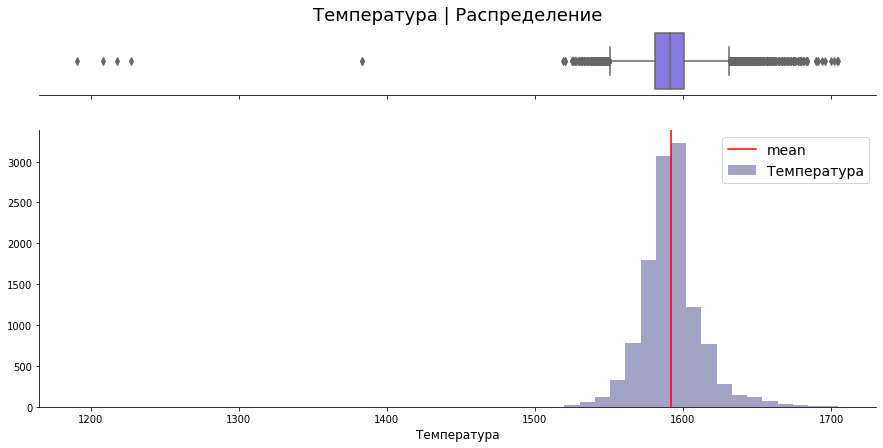

In [86]:
dist_graph(data_temp, 'Температура')

Изучив распределение доступных данных о температуре можно сказать:

* Распределение симметрично


* Есть 5 левых аутлайеров со значением температуры меньшее 1500. Так как температура плавления стали составляет выше 1450 - удалим данные выбросы, так как значения некорректны 

In [87]:
# Вщглянем более детально на партии, содержащие такую низкую температуру

low_temp_key = data_temp[data_temp['Температура'] <= 1450]['key'].values.tolist()

data_temp[data_temp['key'].isin(low_temp_key)]

,key,Время замера,Температура
4350,867,2019-06-04 14:21:00,1191.0
4351,867,2019-06-04 14:29:35,1575.0
4352,867,2019-06-04 14:30:29,1576.0
4353,867,2019-06-04 14:43:10,1571.0
4354,867,2019-06-04 14:52:54,1600.0
4355,867,2019-06-04 14:57:17,1599.0
5978,1214,2019-06-16 05:32:00,1208.0
5979,1214,2019-06-16 05:49:01,1608.0
5980,1214,2019-06-16 05:51:28,1608.0
5981,1214,2019-06-16 05:51:38,1608.0


Во всех партиях, за исключением 1818, низкая температура приходится на 1-2 измерения - не будем удалять такие партии, поскольку в целом такое имеет место быть. В ковш может подаваться не до конца расплавленная сталь на начальном этапе - и только похже ковш начинают разогревать дальше и температура сплава повышается.

Но и 1818 партию мы тоже трогать не будем, поскольку низкая температура в ней возникает не на первом и последнем замерах (которые важны для нас с точки зрения обучающией выборки). Поскольку промежуточные замеры как признаки мы не будем забирать - оставим данную партию в наших данных

### Batches Timeline

At this stage, we will see how the events of feeding of the alloying materials (bulk materials and wire) fit into the interval between the initial and final measurements of the alloy temperature

In [88]:
data_bulk_time['bulk_min'] = data_bulk_time.loc[:, data_bulk_time.columns != 'key'].min(axis=1)
data_bulk_time['bulk_max'] = data_bulk_time.loc[:, data_bulk_time.columns != 'key'].max(axis=1)

data_wire_time['wire_min'] = data_wire_time.loc[:, data_wire_time.columns != 'key'].min(axis=1)
data_wire_time['wire_max'] = data_wire_time.loc[:, data_wire_time.columns != 'key'].max(axis=1)

bulk_wire = pd.merge(data_wire_time[['key','wire_min', 'wire_max']], data_bulk_time[['key','bulk_min', 'bulk_max']],
                    on='key', how='outer')

data_temp_min = pd.pivot_table(data_temp, values='Время замера', index='key', aggfunc='min')
data_temp_max = pd.pivot_table(data_temp, values='Время замера', index='key', aggfunc='max')
time_problem = pd.merge(data_temp_min, data_temp_max, on=['key'], how='inner', suffixes=('_min', '_max'))

problem_time = pd.merge(time_problem, bulk_wire, \
                        on=['key'], how='inner', suffixes=('_min', '_max'))

In [89]:
display(problem_time[(problem_time['wire_min'] < problem_time['Время замера_min']) | \
             (problem_time['bulk_min'] < problem_time['Время замера_min'])])

display(problem_time[(problem_time['wire_max'] > problem_time['Время замера_max']) | \
             (problem_time['bulk_max'] > problem_time['Время замера_max'])])

,key,Время замера_min,Время замера_max,wire_min,wire_max,bulk_min,bulk_max
0,1,2019-05-03 11:16:18,2019-05-03 11:30:39,2019-05-03 11:11:41,2019-05-03 11:11:41,2019-05-03 11:03:52,2019-05-03 11:21:30
2,3,2019-05-03 12:13:17,2019-05-03 12:34:57,2019-05-03 12:13:47,2019-05-03 12:13:47,2019-05-03 12:09:40,2019-05-03 12:31:06
3,4,2019-05-03 12:52:57,2019-05-03 12:59:25,2019-05-03 12:48:05,2019-05-03 12:48:05,2019-05-03 12:41:24,2019-05-03 12:48:43
4,5,2019-05-03 13:23:19,2019-05-03 13:36:01,2019-05-03 13:18:15,2019-05-03 13:32:06,2019-05-03 13:12:56,2019-05-03 13:18:50
7,8,2019-05-03 15:07:18,2019-05-03 15:22:52,2019-05-03 15:03:42,2019-05-03 15:03:42,2019-05-03 14:55:46,2019-05-03 15:04:05
...,...,...,...,...,...,...,...
2399,2494,2019-08-06 00:12:55,2019-08-06 00:23:21,2019-08-06 00:12:37,2019-08-06 00:12:37,2019-08-06 00:07:25,2019-08-06 00:12:53
2400,2495,2019-08-06 00:35:45,2019-08-06 00:54:42,2019-08-06 00:36:13,2019-08-06 00:36:13,2019-08-06 00:32:18,2019-08-06 00:49:21
2402,2497,2019-08-06 01:41:53,2019-08-06 01:53:50,2019-08-06 01:42:27,2019-08-06 01:42:51,2019-08-06 01:38:53,2019-08-06 01:43:02
2403,2498,2019-08-06 02:03:49,2019-08-06 02:25:31,2019-08-06 02:04:20,2019-08-06 02:04:20,2019-08-06 01:59:25,2019-08-06 02:05:26


,key,Время замера_min,Время замера_max,wire_min,wire_max,bulk_min,bulk_max
1195,1244,2019-06-17 08:32:36,2019-06-17 08:45:16,2019-06-17 08:33:55,2019-06-17 08:49:29,2019-06-17 08:49:23,2019-06-17 08:49:23
1264,1316,2019-06-19 17:21:09,2019-06-19 17:34:42,2019-06-19 17:23:55,2019-06-19 17:23:55,2019-06-19 17:35:26,2019-06-19 17:35:26
1437,1493,2019-06-26 05:52:05,2019-06-26 06:47:47,2019-06-26 06:37:40,2019-06-26 06:37:40,2019-06-26 05:56:51,2019-06-26 06:51:49
1449,1505,2019-06-26 14:08:27,2019-06-26 14:14:29,2019-06-26 14:14:50,2019-06-26 14:18:01,2019-06-26 14:17:30,2019-06-26 14:17:30
1492,1549,2019-06-28 05:14:29,2019-06-28 05:32:46,2019-06-28 05:21:40,2019-06-28 05:21:40,2019-06-28 05:17:08,2019-06-28 05:33:18
1809,1873,2019-07-08 21:36:22,2019-07-08 22:09:51,2019-07-08 22:00:47,2019-07-08 22:00:47,2019-07-08 21:39:55,2019-07-08 22:13:14
2060,2137,2019-07-24 15:51:39,2019-07-24 16:53:42,2019-07-24 16:33:10,2019-07-24 16:35:46,2019-07-24 16:24:28,2019-07-24 16:53:54
2330,2421,2019-08-03 08:46:50,2019-08-03 09:06:23,2019-08-03 08:51:33,2019-08-03 08:54:27,2019-08-03 08:49:32,2019-08-03 09:06:24


As we can see, there are quite a lot of such values. Let's fing all the batches that do not fit into the timeline of the data_temp table and delete them to keep the data correct

In [90]:
# search for batches

keys_delete_min = problem_time[(problem_time['wire_min'] < problem_time['Время замера_min']) | \
                               (problem_time['bulk_min'] < problem_time['Время замера_min'])]['key'].unique().tolist()

keys_delete_max = problem_time[(problem_time['wire_max'] > problem_time['Время замера_max']) | \
                               (problem_time['bulk_max'] > problem_time['Время замера_max'])]['key'].unique().tolist()


# remove the batches

print('Удалено партий: {:}'.format((len(keys_delete_min) + len(keys_delete_max))))
print('%: {:.2%}'.format((len(keys_delete_min) + len(keys_delete_max)) / len(data_temp['key'].unique())))

data_temp = data_temp[~data_temp['key'].isin(keys_delete_min)]
data_temp = data_temp[~data_temp['key'].isin(keys_delete_max)]

Удалено партий: 420
%: 17.27%


The same problem can occur for the electrode table **`data_arc`**. Let's check if there are also batches for which heating with electrodes starts before temperature measurement (or vice versa).

In [91]:
data_arc_min = pd.pivot_table(data_arc, values='Начало нагрева дугой', index='key', aggfunc='min')
data_arc_max = pd.pivot_table(data_arc, values='Конец нагрева дугой', index='key', aggfunc='max')

arc_time_problem = pd.merge(data_arc_min, data_arc_max, on=['key'], how='inner', suffixes=('_min', '_max'))

problem_time = pd.merge(time_problem, arc_time_problem, \
                        on=['key'], how='inner', suffixes=('_min', '_max'))

display(problem_time[problem_time['Конец нагрева дугой'] < problem_time['Время замера_min']])

display(problem_time[problem_time['Начало нагрева дугой'] > problem_time['Время замера_max']])

,Время замера_min,Время замера_max,Начало нагрева дугой,Конец нагрева дугой
key,,,,
49,2019-05-05 03:50:08,2019-05-05 04:27:11,2019-05-05 03:45:43,2019-05-05 03:47:49
246,2019-05-12 10:54:47,2019-05-12 11:09:43,2019-05-12 10:50:13,2019-05-12 10:52:22
247,2019-05-12 11:56:26,2019-05-12 12:18:22,2019-05-12 11:51:14,2019-05-12 11:54:29
248,2019-05-12 12:58:56,2019-05-12 13:13:28,2019-05-12 12:53:51,2019-05-12 12:55:58
269,2019-05-13 10:42:47,2019-05-13 10:51:01,2019-05-13 10:37:00,2019-05-13 10:39:09
343,2019-05-16 04:24:32,2019-05-16 04:37:43,2019-05-16 04:21:00,2019-05-16 04:23:48
530,2019-05-22 22:53:46,2019-05-22 23:09:00,2019-05-22 22:48:30,2019-05-22 22:52:31
556,2019-05-24 01:22:16,2019-05-24 01:33:24,2019-05-24 01:19:05,2019-05-24 01:21:10
614,2019-05-26 00:13:20,2019-05-26 00:32:40,2019-05-26 00:10:01,2019-05-26 00:12:13


,Время замера_min,Время замера_max,Начало нагрева дугой,Конец нагрева дугой
key,,,,


In [92]:
# search for batches 

keys_arc_delete = problem_time[(problem_time['Конец нагрева дугой'] < problem_time['Время замера_min']) | \
                    (problem_time['Начало нагрева дугой'] > problem_time['Время замера_max'])].index.tolist()


# remove the batches

print('Удалено партий: {:}'.format(len(keys_arc_delete)))
print('%: {:.2%}'.format(len(keys_arc_delete) / len(data_temp['key'].unique())))

data_temp = data_temp[~data_temp['key'].isin(keys_arc_delete)]

Удалено партий: 31
%: 1.54%


## Project Plan

**1) Formation of features and training set:**

 - **target**: final temperature measurement (*time*) within the batch
    
    
  - **features**:
      1. initial temperature measurement
      2. apparent power (sq. root of sum of squares of given powers)
      3. steel processing cycle time (difference between the initial and final temperature measurements of the alloy (including in min & in sec)
      4. Aggregated number of alloying bulk materials per batch (*average*)
      5. Aggregate number of alloying wire by batch (*average*)
      6. The volume of the gas used
      7. Total operating time of heating elements (electrodes)
      8. Total number of electrode heatings within one batch (*number of times*)
      
The training dataframe will be grouped by batches (key) - all batch values will be taken completely from the **data_temp** table.

(Also formation of test and validation samples)

**2) Training and modeling stage**:

Both simple models (*LinearRegression*, *DecisionTreeRegressor*, *RandomForestRegressor*) and more complex ones (Gradient Boosting models: *LGBM*, *CatBoost*) will be considered.

**3) Checking factors for multicollinearity**

**4) Choosing the best model based on the MAE metric**

**5) Sanity check**
    
**6) Feature Importance Analysis**

## Training Sample Formation | Features Generation

As noted earlier in the project plan, the final dataframe (training sample) will be grouped by batches ( `key` ) - all batch values will be taken completely from the **data_temp** table, since it contains information about which objects have the target.

### Features Generation

* **initial temperature measurement** / `data_temp`
* **time of steel processing cycle** (*min*) / `data_temp`
* **apparent power** / `data_arc`
* **total operating time of heating elements (electrodes) work** (*min*) / `data_arc`
* **total number of electrode heatings within one batch** (*number of times*) / `data_arc`
* **aggregated number of alloying bulk materials by batch** (*sum*) / `data_bulk`
* **aggregated number of alloy wire per batch** (*sum*) / `data_wire`
* **volume of used gas** / `data_gas`

#### Initial Temperature Measurement 

In [93]:
data_temp_min = pd.pivot_table(data_temp, values='Время замера', index='key', aggfunc='min')
data_temp_mintemp = pd.merge(data_temp_min, data_temp, on=['key', 'Время замера'], how='inner')

feature_data_temp_temp_start = data_temp_mintemp[['key', 'Температура']].rename(columns={'Температура':'temp_start'})
feature_data_temp_temp_start.head(5)

,key,temp_start
0,2,1581.0
1,6,1543.0
2,7,1586.0
3,9,1587.0
4,10,1574.0


#### Time of Steel Processing Cycle

In [94]:
data_temp_max = pd.pivot_table(data_temp, values='Время замера', index='key', aggfunc='max')
data_temp_min_max = pd.merge(data_temp_min, data_temp_max, how='inner', on='key', suffixes=('_min', '_max'))

data_temp_min_max['time_cycle'] = \
    (data_temp_min_max['Время замера_max'] - data_temp_min_max['Время замера_min']) / pd.Timedelta(minutes=1)

data_temp_min_max.reset_index(level=0, inplace=True)
# data_temp_min_max.head(10)

feature_data_temp_time_cycle = data_temp_min_max[['key', 'time_cycle']]
feature_data_temp_time_cycle.head(5)

,key,time_cycle
0,2,21.750000
1,6,23.083333
2,7,22.900000
3,9,24.216667
4,10,21.650000


#### Apparent Power

In [95]:
data_arc['apparent_power'] = (data_arc['Активная мощность'] ** 2 + data_arc['Реактивная мощность'] ** 2).apply(np.sqrt)

feature_data_arc_apparent_power_pre = data_arc[['key', 'apparent_power']]
feature_data_arc_apparent_power_pre.head(5)

,key,apparent_power
0,1,1.193639
1,1,0.959010
2,1,0.896038
3,1,1.970470
4,1,0.807239


In [96]:
#  Take the sum of apparent power within batch

feature_data_arc_apparent_power = pd.pivot_table(data=feature_data_arc_apparent_power_pre, values='apparent_power', \
                                                 index='key', aggfunc='sum')
feature_data_arc_apparent_power.reset_index(level=0, inplace=True)

feature_data_arc_apparent_power.head(5)

,key,apparent_power
0,1,5.826395
1,2,3.649216
2,3,2.989534
3,4,3.814962
4,5,4.035758


#### Total Operating Time of Heating Elements (electrodes) Work

In [97]:
data_arc_min = pd.pivot_table(data_arc, values='Начало нагрева дугой', index='key', aggfunc='min')
data_arc_max = pd.pivot_table(data_arc, values='Конец нагрева дугой', index='key', aggfunc='max')

data_arc_min_max = pd.merge(data_arc_max, data_arc_min, on='key', how='inner')

data_arc_min_max['electrode_time'] = \
    (data_arc_min_max['Конец нагрева дугой'] - data_arc_min_max['Начало нагрева дугой']) / pd.Timedelta(minutes=1)

data_arc_min_max.reset_index(level=0, inplace=True)
feature_data_arc_electrode_time = data_arc_min_max[['key','electrode_time']]

feature_data_arc_electrode_time.head(5)

,key,electrode_time
0,1,26.383333
1,2,19.066667
2,3,25.416667
3,4,18.216667
4,5,22.700000


#### Total Number of Electrode Heatings within one Batch 

In [98]:
data_arc_count = pd.pivot_table(data_arc, values='Конец нагрева дугой', index='key', aggfunc='count')
data_arc_count.reset_index(level=0, inplace=True)

feature_data_arc_electrode_count = \
    data_arc_count[['key', 'Конец нагрева дугой']].rename(columns={'Конец нагрева дугой':'electrode_count'})

feature_data_arc_electrode_count.head(5)

,key,electrode_count
0,1,5
1,2,4
2,3,5
3,4,4
4,5,4


#### Aggregated Number of Alloying Bulk Materials by Batch 

In [99]:
data_bulk['bulk'] = data_bulk.loc[:, data_bulk.columns != 'key'].sum(axis=1)

feature_data_bulk_bulk = data_bulk[['key', 'bulk']]

feature_data_bulk_bulk.head(5)

,key,bulk
0,1,553.0
1,2,582.0
2,3,544.0
3,4,595.0
4,5,584.0


#### Aggregated Number of Alloy Wire per Batch

In [100]:
data_wire['wire'] = data_wire.loc[:, data_wire.columns != 'key'].sum(axis=1)

feature_data_wire_wire = data_wire[['key', 'wire']]

feature_data_wire_wire.head(5)

,key,wire
0,1,60.059998
1,2,96.052315
2,3,91.160157
3,4,89.063515
4,5,98.352796


#### Volume of Used Gas

In [101]:
feature_data_gas_gas = data_gas[['key', 'Газ 1']].rename(columns={'Газ 1':'gas'})

feature_data_gas_gas.head(5)

,key,gas
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


### Target

The target variable for model forecast is the final temperature measurement for the batch after the end of the entire steel processing cycle - available in the **`data_temp`** table

In [102]:
data_temp_max = pd.pivot_table(data_temp, values='Время замера', index='key', aggfunc='max')
data_temp_maxtemp = pd.merge(data_temp_max, data_temp, on=['key', 'Время замера'], how='inner')

feature_data_temp_temp_end = data_temp_maxtemp[['key', 'Температура']].rename(columns={'Температура':'temp_end'})
feature_data_temp_temp_end.head(5)

,key,temp_end
0,2,1602.0
1,6,1596.0
2,7,1599.0
3,9,1592.0
4,10,1593.0


### Training Sample

The training dataframe will be grouped by batches (key) - all of the batch values will be taken from the **data_temp** table

In [103]:
data_frames = [feature_data_temp_temp_end, feature_data_temp_temp_start, feature_data_temp_time_cycle, \
                 feature_data_arc_apparent_power, feature_data_arc_electrode_time, \
                 feature_data_arc_electrode_count, feature_data_bulk_bulk, feature_data_wire_wire, \
                 feature_data_gas_gas]

data = reduce(lambda left,right: pd.merge(left,right,on=['key'],
                                            how='left'), data_frames)
data.set_index('key', inplace=True)

data.head(10)

,temp_end,temp_start,time_cycle,apparent_power,electrode_time,electrode_count,bulk,wire,gas
key,,,,,,,,,
2,1602.0,1581.0,21.750000,3.649216,19.066667,4,582.0,96.052315,12.555561
6,1596.0,1543.0,23.083333,4.786837,22.550000,4,676.0,108.224477,11.273392
7,1599.0,1586.0,22.900000,2.987777,24.483333,4,627.0,98.061600,9.836267
9,1592.0,1587.0,24.216667,2.555348,26.100000,5,526.0,122.536960,8.216623
10,1593.0,1574.0,21.650000,3.851739,23.700000,6,509.0,93.620796,6.529891
11,1597.0,1616.0,33.083333,2.863314,39.883333,5,579.0,99.197281,3.639128
12,1591.0,1606.0,32.150000,3.350069,34.050000,4,1307.0,153.578873,11.026259
13,1619.0,1596.0,27.266667,5.138650,30.333333,6,837.0,129.685923,11.443643
14,1606.0,1583.0,37.666667,5.690572,41.033333,6,630.0,158.077919,5.098945


In [104]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1988 entries, 2 to 2496
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   temp_end         1988 non-null   float64
 1   temp_start       1988 non-null   float64
 2   time_cycle       1988 non-null   float64
 3   apparent_power   1988 non-null   float64
 4   electrode_time   1988 non-null   float64
 5   electrode_count  1988 non-null   int64  
 6   bulk             1929 non-null   float64
 7   wire             1895 non-null   float64
 8   gas              1986 non-null   float64
dtypes: float64(8), int64(1)
memory usage: 155.3 KB


#### Missing Values

We see there are gaps for the fields `bulk`, `wire`

Let's replace fields' missing values with 0

In [105]:
data = data.fillna(0)

data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1988 entries, 2 to 2496
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   temp_end         1988 non-null   float64
 1   temp_start       1988 non-null   float64
 2   time_cycle       1988 non-null   float64
 3   apparent_power   1988 non-null   float64
 4   electrode_time   1988 non-null   float64
 5   electrode_count  1988 non-null   int64  
 6   bulk             1988 non-null   float64
 7   wire             1988 non-null   float64
 8   gas              1988 non-null   float64
dtypes: float64(8), int64(1)
memory usage: 155.3 KB


#### Checking Factors for Multicollinearity

In order to avoid the problem of multicollinearity, which can make our forecasts inaccurate and the model useless, we will check the factors for multicollinearity

Text(0.5, 1.0, 'Корреляция между факторами')

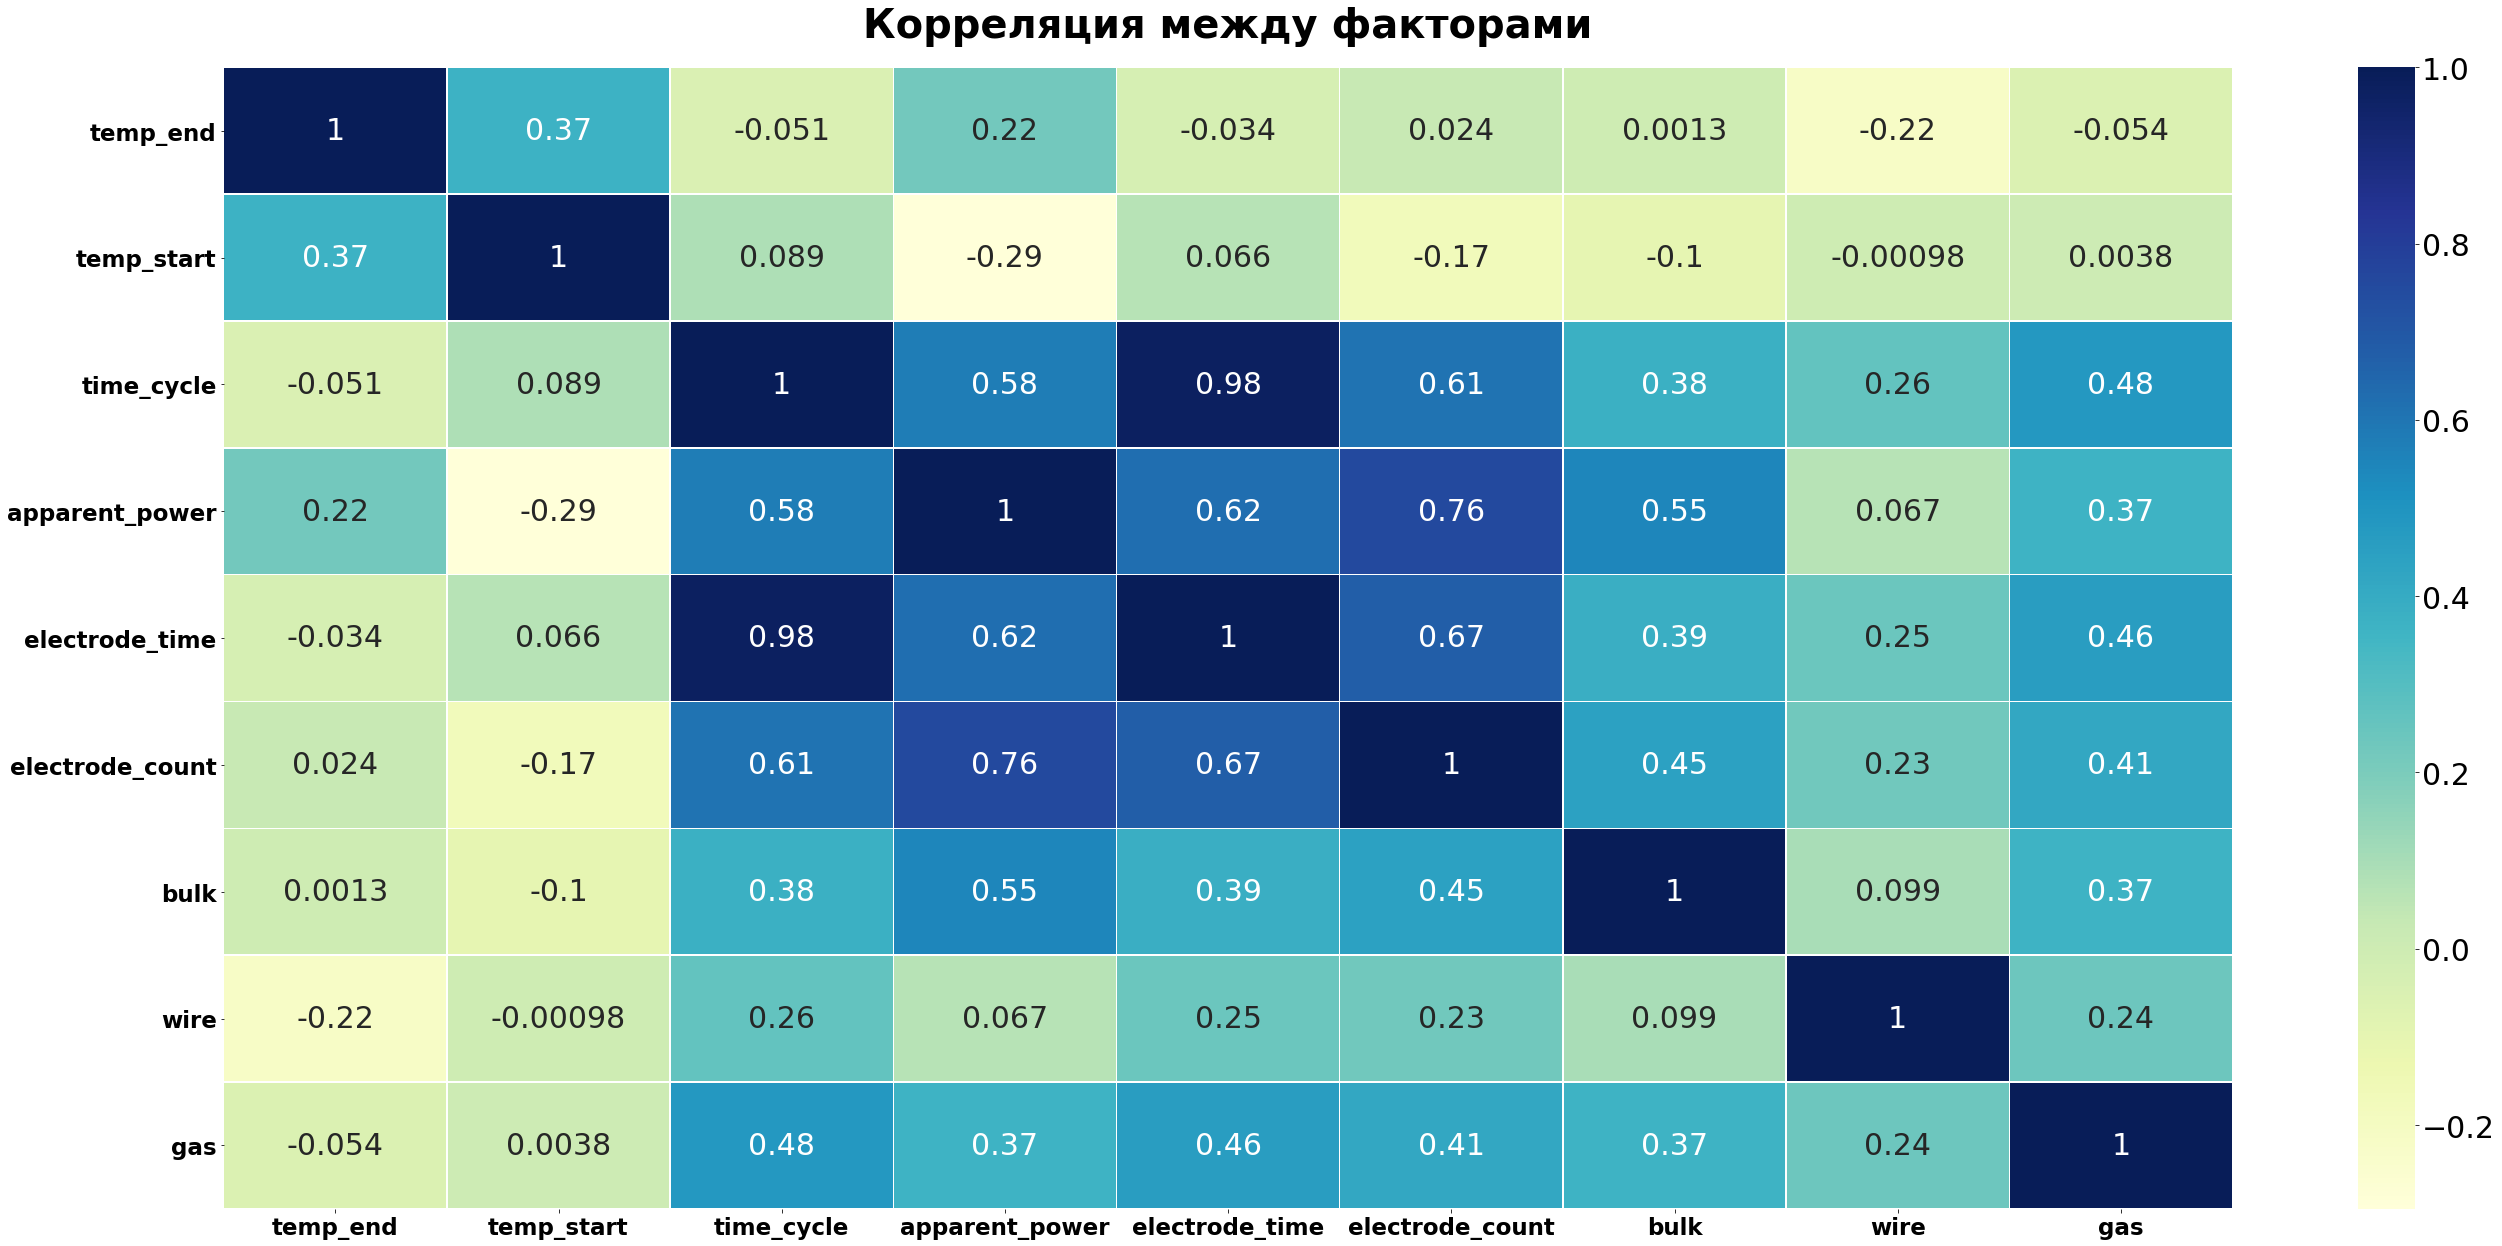

In [106]:
fig, ax = plt.subplots(figsize=(45,21))   
a = sns.heatmap(data.corr(), annot=True, cmap='YlGnBu', linewidths=0.5, annot_kws={"size":30})

a.set_xticklabels(a.get_xticklabels(), fontsize=23, weight='bold')
a.set_yticklabels(a.get_yticklabels(), fontsize=23, weight='bold', rotation=0)
cax = plt.gcf().axes[-1]
cax.tick_params(labelsize=30)
plt.title('Корреляция между факторами', pad=30, fontsize=40, weight='bold')

Thus, we can observe a high correlation for factors:

* **`electrode_time`** and **`time_cycle`** *>90%*

Which is reasonable. After all, the time frame between the start and the end will practically coincide and differ by only a few minutes. Let's take the time of the whole cycle: **`time_cycle`**

---

* **`electrode_count`** and **`apparent_power`** *>70%*

Let's take apparent power: **`apparent_power`**

In [107]:
# Get rid of problematic fields

data.drop(['electrode_time', 'electrode_count'], axis=1, inplace=True)

data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1988 entries, 2 to 2496
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   temp_end        1988 non-null   float64
 1   temp_start      1988 non-null   float64
 2   time_cycle      1988 non-null   float64
 3   apparent_power  1988 non-null   float64
 4   bulk            1988 non-null   float64
 5   wire            1988 non-null   float64
 6   gas             1988 non-null   float64
dtypes: float64(7)
memory usage: 124.2 KB


Finally, the final training sample is ready. Further, also when dividing the data into samples, we will standardize the data.

## Samples

### Samples Formation

There is no prepared separate test set. This means that the data needs to be divided into **three parts**: training, validation and test. The sizes of the test and validation sets are usually equal. Let's split the initial data in the ratio **3:1:1**

In [108]:
# Let's first divide our initial dataset into a training sample [train] and a sample allocated for 
# test and validation [add]
train, add = train_test_split(data, test_size=0.4, random_state=12345)

# Divide the remaining dataset into validation [valid] and test [test] samples
test, valid = train_test_split(add, test_size=0.5, random_state=12345)


# Check if we have correctly divided our samples according to our preferences
samples = [train, test, valid]
train.name = 'Обучающая выборка'
test.name = 'Тестовая выборка'
valid.name = 'Валидационнная выборка'

for df in samples:
    print(df.name, ': {:2}'.format(round(df.shape[0] / data.shape[0], 2)))

Обучающая выборка : 0.6
Тестовая выборка : 0.2
Валидационнная выборка : 0.2


### Feature Extraction for Training

In [109]:
# Training sample
features_train = train.drop(['temp_end'], axis=1)
target_train = train['temp_end']

# Test sample
features_test = test.drop(['temp_end'], axis=1)
target_test = test['temp_end']

# Validation sample
features_valid = valid.drop(['temp_end'], axis=1)
target_valid = valid['temp_end']

### Feature Scaling

Obviously, the dimensions of such fields as `temp_start` and `apparent_power` or `gas` (etc.) will be very different. Without feature scaling, we might run into a problem - algorithms might decide that higher values might have more effect than smaller values - hence deciding that some features are even more important than others. Although in reality this is not the case at all. We scale our features to avoid this trap.

Let's use the standardization method.

In [110]:
numeric = ['temp_start', 'time_cycle', 'apparent_power', 'bulk', 'wire', 'gas']

scaler = StandardScaler()
scaler.fit(features_train[numeric])

features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

## Model Training 

### Function for generating a table with results

In [111]:
results = pd.DataFrame(columns = ['Model', 'MAE', 'Learning Time', 'Prediction Time'])

def fill_result(model, mae, learn_time, pred_time):
    
    global results
    results = results.append({'Model': model, \
                              'MAE': mae, \
                              'Learning Time': learn_time, \
                              'Prediction Time': pred_time}, ignore_index=True)
    
    return results

### Simple Models

#### Linear Regression

In [112]:
model_reg = LinearRegression()

learn_start = time.time()
model_reg.fit(features_train, target_train)
learn_dur = time.time() - learn_start

predict_start = time.time()
predicted_valid = model_reg.predict(features_valid)
predict_dur = time.time() - predict_start

mae_reg = mean_absolute_error(target_valid, predicted_valid)

fill_result(type(model_reg).__name__, mae_reg, learn_dur, predict_dur)

,Model,MAE,Learning Time,Prediction Time
0,LinearRegression,8.212323,0.002907,0.001665


#### Decision Tree

###### Parameters Tuning

In [113]:
params_tree = {'max_depth': range(1, 101, 10),
              'min_samples_leaf': range (1,8),
              'min_samples_split': range (2,10,2),
              'criterion': ['mae']}

###### Training

In [114]:
model_tree = DecisionTreeRegressor(random_state=12345) 

grid_cv_tree = GridSearchCV(estimator = model_tree,
                            param_grid = params_tree,
                            scoring = 'neg_mean_absolute_error',
                            cv = 5)

learn_start = time.time()
grid_cv_tree.fit(features_train, target_train)
learn_dur = time.time() - learn_start

predict_start = time.time()
predicted_valid = grid_cv_tree.best_estimator_.predict(features_valid)
predict_dur = time.time() - predict_start

mae_tree = mean_absolute_error(target_valid, predicted_valid)

fill_result(type(grid_cv_tree.best_estimator_).__name__, mae_tree, learn_dur, predict_dur)

,Model,MAE,Learning Time,Prediction Time
0,LinearRegression,8.212323,0.002907,0.001665
1,DecisionTreeRegressor,7.434673,76.857587,0.001792


In [115]:
grid_cv_tree.best_params_

{'criterion': 'mae',
 'max_depth': 11,
 'min_samples_leaf': 7,
 'min_samples_split': 2}

#### Random Forest params

###### Parameters Tuning

In [116]:
params_forest = {'max_depth': range(1, 21, 5),
                 'n_estimators': range(1, 31, 4),
                 'criterion': ['mae']}

###### Training

In [117]:
model_forest = RandomForestRegressor(random_state=12345) 

grid_cv_forest = GridSearchCV(estimator = model_forest,
                              param_grid = params_forest,
                              scoring = 'neg_mean_absolute_error',
                              cv = 5)

learn_start = time.time()
grid_cv_forest.fit(features_train, target_train)
learn_dur = time.time() - learn_start

predict_start = time.time()
predicted_valid = grid_cv_forest.best_estimator_.predict(features_valid)
predict_dur = time.time() - predict_start

mae_forest = mean_absolute_error(target_valid, predicted_valid)

fill_result(type(grid_cv_forest.best_estimator_).__name__, mae_forest, learn_dur, predict_dur)

,Model,MAE,Learning Time,Prediction Time
0,LinearRegression,8.212323,0.002907,0.001665
1,DecisionTreeRegressor,7.434673,76.857587,0.001792
2,RandomForestRegressor,6.574171,53.751332,0.005184


In [118]:
grid_cv_forest.best_params_

{'criterion': 'mae', 'max_depth': 11, 'n_estimators': 25}

### More Complex Models

#### LGBMRegressor

###### Parameters Tuning

In [119]:
params_lgbm = {'learning_rate': np.arange(0.01, 0.51, 0.05),
               'n_estimators': range(1, 301, 50)}

###### Training

In [120]:
model_lgbm = LGBMRegressor(random_state=12345)

grid_cv_lgbm = GridSearchCV(estimator = model_lgbm,
                              param_grid = params_lgbm,
                              scoring = 'neg_mean_absolute_error',
                              cv = 5)

learn_start = time.time()
grid_cv_lgbm.fit(features_train, target_train)
learn_dur = time.time() - learn_start

predict_start = time.time()
predicted_valid = grid_cv_lgbm.best_estimator_.predict(features_valid)
predict_dur = time.time() - predict_start

mae_lgbm = mean_absolute_error(target_valid, predicted_valid)

fill_result(type(grid_cv_lgbm.best_estimator_).__name__, mae_lgbm, learn_dur, predict_dur)

,Model,MAE,Learning Time,Prediction Time
0,LinearRegression,8.212323,0.002907,0.001665
1,DecisionTreeRegressor,7.434673,76.857587,0.001792
2,RandomForestRegressor,6.574171,53.751332,0.005184
3,LGBMRegressor,6.604579,375.417538,0.003046


In [121]:
grid_cv_lgbm.best_params_

{'learning_rate': 0.060000000000000005, 'n_estimators': 101}

#### CatBoostRegressor

###### Parameters Tuning

In [122]:
params_cat = {'learning_rate': [0.1, 0.15, 0.2, 0.25],
              'iterations': [200,300,400,500]}

###### Training

In [123]:
model_cat = CatBoostRegressor(random_state=12345, verbose=False)

grid_cv_cat = GridSearchCV(estimator = model_cat,
                              param_grid = params_cat,
                              scoring = 'neg_mean_absolute_error',
                              cv = 5)

learn_start = time.time()
grid_cv_cat.fit(features_train, target_train)
learn_dur = time.time() - learn_start

predict_start = time.time()
predicted_valid = grid_cv_cat.best_estimator_.predict(features_valid)
predict_dur = time.time() - predict_start

mae_cat = mean_absolute_error(target_valid, predicted_valid)

In [124]:
fill_result(type(grid_cv_cat.best_estimator_).__name__, mae_cat, learn_dur, predict_dur)

,Model,MAE,Learning Time,Prediction Time
0,LinearRegression,8.212323,0.002907,0.001665
1,DecisionTreeRegressor,7.434673,76.857587,0.001792
2,RandomForestRegressor,6.574171,53.751332,0.005184
3,LGBMRegressor,6.604579,375.417538,0.003046
4,CatBoostRegressor,6.281229,96.229257,0.001455


In [125]:
grid_cv_cat.best_params_

{'iterations': 200, 'learning_rate': 0.2}

### Conclusion

Therefore, it can be seen that the best result among the studied models was given by the **CatBoostRegressor** model with the following parameters:

* **`iterations` = 200**

* **`learning_rate` = 0.1**

---

On average, the model is wrong by 6 degrees - **MAE on the validation set** is **6.28**

### Analysis of the Selected Model

#### Model Check on a Test Set

In [126]:
predicted_test = grid_cv_cat.best_estimator_.predict(features_test)
mae_test = mean_absolute_error(target_test, predicted_test)

print('CatBoostRegressor | MAE | Тестовая выборка: {:2f}'.format(mae_test))

CatBoostRegressor | MAE | Тестовая выборка: 6.675280


#### Model Sanity Check

In [127]:
dummy_regressor = DummyRegressor(strategy="median") 

dummy_regressor.fit(features_train, target_train)
dummy_predicted = dummy_regressor.predict(features_test)
mae_dummy = mean_absolute_error(target_test, dummy_predicted)

print('MAE константной модели:', mae_dummy)

MAE константной модели: 10.321608040201005


Model passed **Sanity Check**

#### Feature Importance Analysis

Text(0.5, 1.0, 'Анализ важности признаков модели')

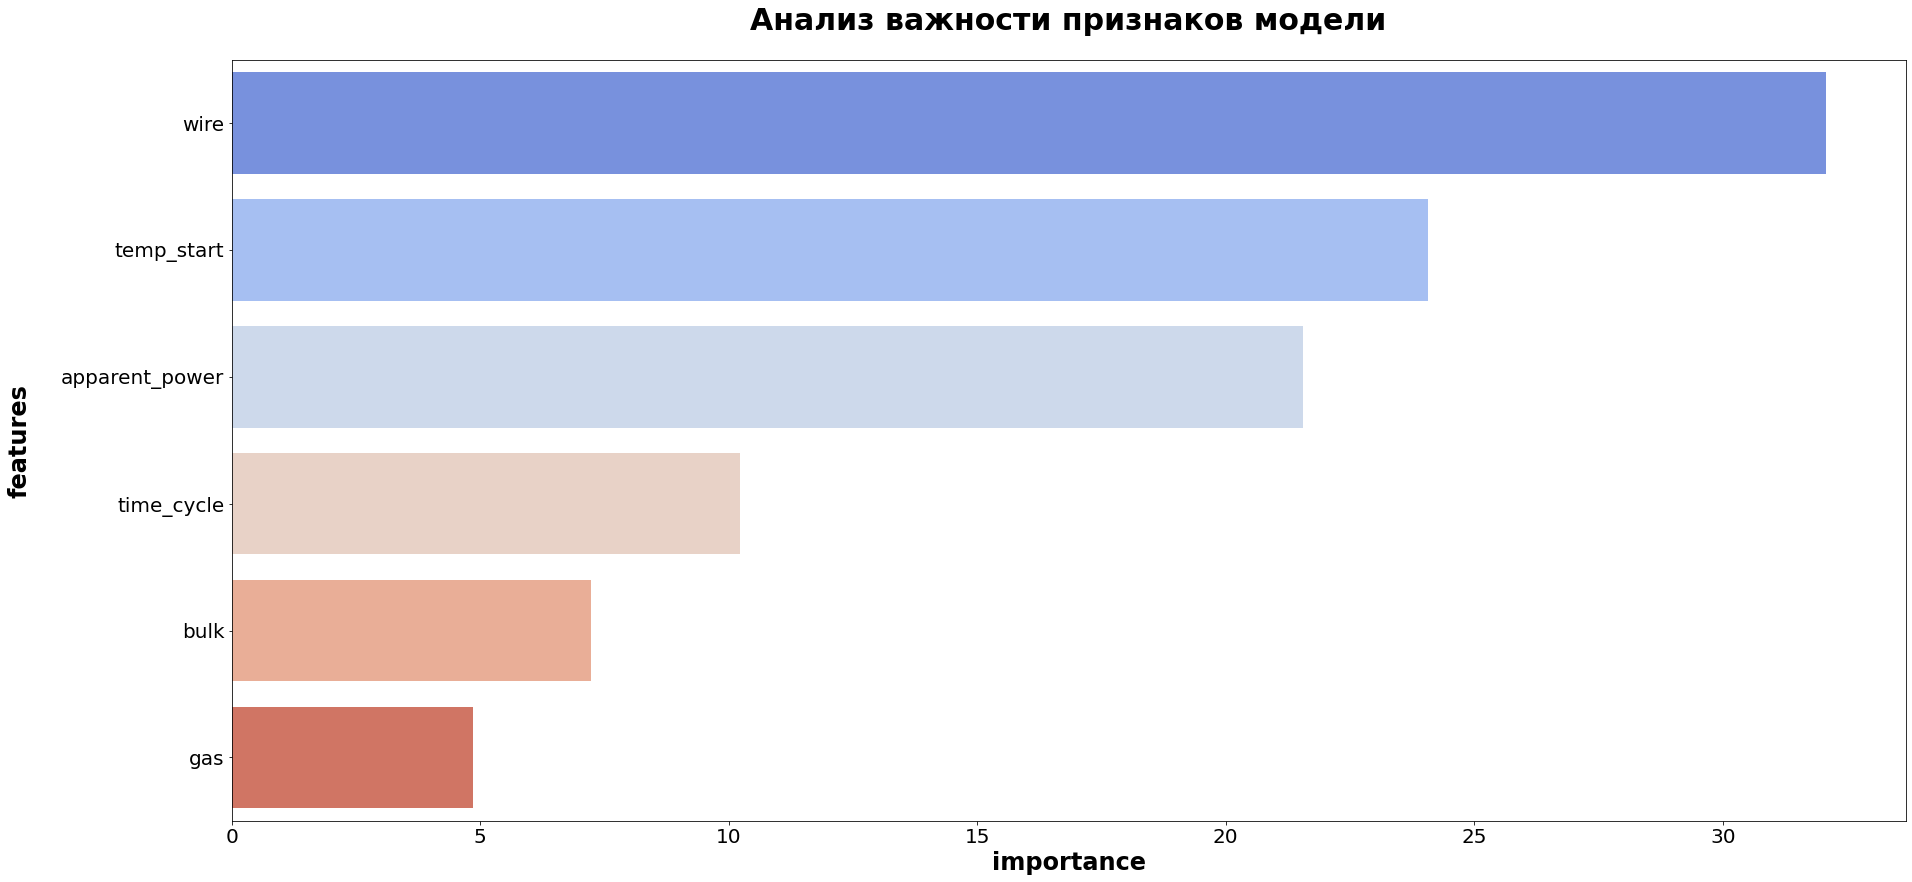

In [128]:
feature_importance =pd.DataFrame({'feature':features_train.columns,
                                  'importance': grid_cv_cat.best_estimator_.feature_importances_}\
                                ).sort_values('importance', ascending=False)

fig, ax = plt.subplots(figsize=(30,14))
a = sns.barplot(x='importance', y='feature', data=feature_importance, palette=sns.color_palette("coolwarm"))

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('importance', size=24, weight='bold')
plt.ylabel('features', size=24, labelpad=30, weight='bold')
plt.title('Анализ важности признаков модели', pad=30, fontsize=30, weight='bold')

Thus, we can see that the model considered the amount of alloying wire **`wire` to be the most important feature**. Whereas the **most useless** features for learning turned out to be the value of **added gas `gas`** and **number of alloying bulk materials `bulk`**

## Report

In this project, data from the steel processing cycle was analyzed (including temperature measurements, power used, data on heating electrodes and the amount of alloying materials used and gas that changes the chemical composition of the steel and its temperature). The main objective of the project was to create a model capable of predicting the steel temperature at the final measurement after the entire cycle.

---

**Project plan** was as follows:
    
1) Examining available data

2) Data processing 

3) Consultation with the team leader on the process of completing the task / clarification of questions

4) Formation of features of the model and training sample

5) Study of simple and more complex models (with the selection of acceptable parameters)

6) Analysis of the resulting model (checking on a test sample, sanity check, feature importance)

*Each of the main stages of the project was completed*

----

**Final model**:

- **`CatBoostRegressor`**


**Parameters**:

- **`iterations`** = 200


- **`learning_rate`** = 0.1


**Model quality**:

- **MAE** | *Test sample* = 6.6753